# Notebook de conversión de ficheros xml a df

## Cargar librerias

In [64]:
import numpy as np
import pandas as pd
# import tensorflow
# from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,Input
# from tensorflow.keras.models import Model,Sequential
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import io
import os
# from tensorflow.keras.preprocessing.image import img_to_array,load_img
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
# from tensorflow.keras.models import load_model
import random
import imutils
import xml.etree.ElementTree as ET

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

## Definición de función *random_images* 
La función tiene como argumento un df que contiene las direcciones de las imágenes y sus rectángulos delimitadores y como segundo argumento el número 4 ó 9. La función devuelve 4 ó 9 imágenes aleatorias con sus cuadros delimitadores.

In [65]:
def random_images(df, number):
# función para mostrar aleatoriamente imagenes con sus objetos múltiples o no a detectar     
    ix = 0
    if number == 4:
        thickness = 2
        font_size = .5
        plt.figure(figsize=(5,5))
    elif number == 9:
        thickness = 2
        font_size = 1
        plt.figure(figsize=(6, 6))
    else:
        print("Inserte 4 ó 9")

    for i in range(number):
        a = random.choice(df.index)
        #photo = plt.imread(df["image"][a]) # lee la columna con el nombre de la imagen
        photo = load_img(df["image"][a], target_size=(224,224))
        photo = img_to_array(photo)/255
        v,h,_ = img_to_array(load_img(df["image"][a])).shape 
        
        # Agregar múltiples objetos 
        ndf = df[df.image == df.image[a]]
        print(f"image: {df['image'][a]}, tiene {ndf.shape[0]} coches en la imagen") 
        for obj in list(ndf.index):
            pt1=(int(ndf["xmin"][obj]/h*224),int(ndf['ymin'][obj]/v*224)) #xmin, ymin
            pt2=(int(ndf['xmax'][obj]/h*224),int(ndf['ymax'][obj]/v*224)) #xmax, ymax
            color=(0,1, 0)
            #thickness = 1
            cv2.putText(photo, ndf['label'][obj], pt1, cv2.FONT_HERSHEY_SIMPLEX,.5, (0, 1, 0), thickness, cv2.LINE_AA)
            cv2.rectangle(photo,pt1,pt2, color, thickness)
                    
        #plt.figure()
        plt.subplot(int(number**.5),int(number**.5), ix+1)
        plt.imshow(photo , extent=[0, 224, 0, 224]) # con extent se ajusta la imagen a 224x224
        ix+=1
        if ix >number:
            break
    plt.tight_layout()
    plt.show()

## Cargar datos
### Datos de CarsObjectDetection

In [67]:
# Cargar df de car_object_detection
df_cod = pd.read_csv("/Users/luispalma/Documentos/Master en IA3/2. Aprendijaze Profundo I/Trabajo final de DO/car_detection/car_object_detection/train_solution_bounding_boxes (1).csv")
df_cod['label'] = 'car'
df_cod.image = df_cod.image.apply(lambda x: str("car_object_detection/training_images/")+x)
#df_cod.iloc[:,] = df_cod.astype(int)
df_cod.iloc[:,1:5] = df_cod.iloc[:,1:5].astype(int)
df_cod

,image,xmin,ymin,xmax,ymax,label
0,car_object_detection/training_images/vid_4_100...,281,187,327,223,car
1,car_object_detection/training_images/vid_4_100...,15,187,120,236,car
2,car_object_detection/training_images/vid_4_100...,239,176,361,236,car
3,car_object_detection/training_images/vid_4_100...,496,172,630,231,car
4,car_object_detection/training_images/vid_4_100...,16,186,132,238,car
...,...,...,...,...,...,...
554,car_object_detection/training_images/vid_4_986...,0,198,49,236,car
555,car_object_detection/training_images/vid_4_988...,329,156,536,250,car
556,car_object_detection/training_images/vid_4_990...,0,168,141,239,car
557,car_object_detection/training_images/vid_4_996...,487,172,616,228,car


image: car_object_detection/training_images/vid_4_26520.jpg, tiene 3 coches en la imagen
image: car_object_detection/training_images/vid_4_2160.jpg, tiene 3 coches en la imagen
image: car_object_detection/training_images/vid_4_2040.jpg, tiene 4 coches en la imagen
image: car_object_detection/training_images/vid_4_18180.jpg, tiene 1 coches en la imagen
image: car_object_detection/training_images/vid_4_26440.jpg, tiene 5 coches en la imagen
image: car_object_detection/training_images/vid_4_16500.jpg, tiene 1 coches en la imagen
image: car_object_detection/training_images/vid_4_12480.jpg, tiene 1 coches en la imagen
image: car_object_detection/training_images/vid_4_16500.jpg, tiene 1 coches en la imagen
image: car_object_detection/training_images/vid_4_6480.jpg, tiene 2 coches en la imagen


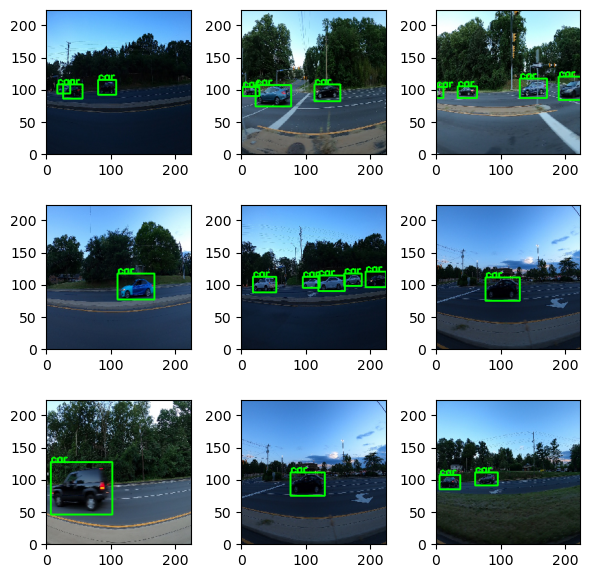

In [87]:
random_images(df_cod, 9)

### Datos de coches de universidad de Standford

In [69]:
# Convertir los ficheros xml a tabla
# https://github.com/heartexlabs/labelImg
files_path = "/Users/luispalma/Documentos/Master en IA3/2. Aprendijaze Profundo I/Trabajo final de DO/car_detection/standford_cardataset/cars_train/cars_train"
data = []
xml_dir = files_path # reemplazar con la ruta del directorio que contiene los archivos XML
for filename in os.listdir(xml_dir):
    if filename.endswith('.xml'):
        filepath = os.path.join(xml_dir, filename)
        tree = ET.parse(filepath)
        root = tree.getroot()

        # Extraer la información necesaria del archivo XML y agregarla a la lista "data"
        for obj in root.findall('object'):
            name = obj.find('name').text
            #path = str(root.find('path').text)
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)
            data.append([filename, name, xmin, ymin, xmax, ymax])

# Convertir la lista "data" en un objeto DataFrame de Pandas
df_sf = pd.DataFrame(data, columns=['image', 'label', 'xmin', 'ymin', 'xmax', 'ymax'])
df_sf.sort_values("image", inplace=True)
df_sf.reset_index(inplace=True, drop=True)
df_sf.image = df_sf.image.apply(lambda x: str('standford_cardataset/cars_train/cars_train/')+x.replace("xml","jpg"))
df_sf

,image,label,xmin,ymin,xmax,ymax
0,standford_cardataset/cars_train/cars_train/000...,car,44,108,557,369
1,standford_cardataset/cars_train/cars_train/000...,car,61,134,845,593
2,standford_cardataset/cars_train/cars_train/000...,car,78,106,603,384
3,standford_cardataset/cars_train/cars_train/000...,car,601,374,1508,1114
4,standford_cardataset/cars_train/cars_train/000...,car,14,34,131,99
...,...,...,...,...,...,...
678,standford_cardataset/cars_train/cars_train/071...,car,5,51,256,146
679,standford_cardataset/cars_train/cars_train/071...,car,58,59,372,214
680,standford_cardataset/cars_train/cars_train/072...,car,13,56,1018,728
681,standford_cardataset/cars_train/cars_train/072...,car,86,103,485,380


image: standford_cardataset/cars_train/cars_train/00214.jpg, tiene 3 coches en la imagen
image: standford_cardataset/cars_train/cars_train/00341.jpg, tiene 4 coches en la imagen
image: standford_cardataset/cars_train/cars_train/00033.jpg, tiene 11 coches en la imagen
image: standford_cardataset/cars_train/cars_train/00094.jpg, tiene 1 coches en la imagen
image: standford_cardataset/cars_train/cars_train/00250.jpg, tiene 6 coches en la imagen
image: standford_cardataset/cars_train/cars_train/00301.jpg, tiene 1 coches en la imagen
image: standford_cardataset/cars_train/cars_train/00413.jpg, tiene 5 coches en la imagen
image: standford_cardataset/cars_train/cars_train/00023.jpg, tiene 1 coches en la imagen
image: standford_cardataset/cars_train/cars_train/00352.jpg, tiene 1 coches en la imagen


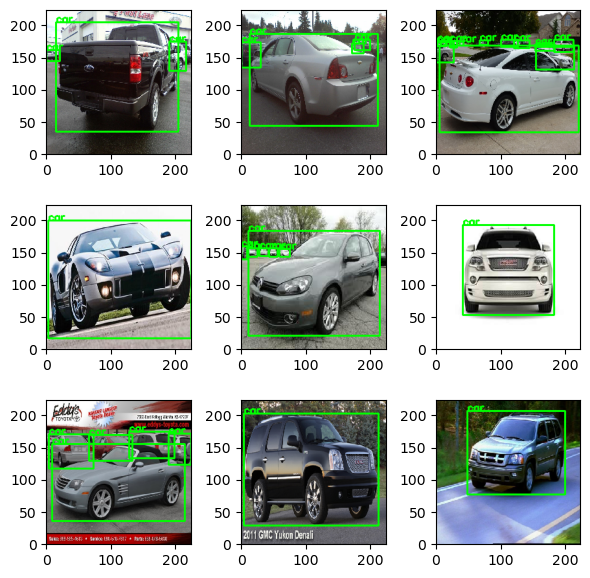

In [88]:
random_images(df_sf, 9)

### Unión de dataframes 

In [71]:
# Unir dataframes df_cod y df_sf 
df_train = pd.concat([df_cod, df_sf]).reset_index(drop=True)
df_train

,image,xmin,ymin,xmax,ymax,label
0,car_object_detection/training_images/vid_4_100...,281,187,327,223,car
1,car_object_detection/training_images/vid_4_100...,15,187,120,236,car
2,car_object_detection/training_images/vid_4_100...,239,176,361,236,car
3,car_object_detection/training_images/vid_4_100...,496,172,630,231,car
4,car_object_detection/training_images/vid_4_100...,16,186,132,238,car
...,...,...,...,...,...,...
1237,standford_cardataset/cars_train/cars_train/071...,5,51,256,146,car
1238,standford_cardataset/cars_train/cars_train/071...,58,59,372,214,car
1239,standford_cardataset/cars_train/cars_train/072...,13,56,1018,728,car
1240,standford_cardataset/cars_train/cars_train/072...,86,103,485,380,car


image: standford_cardataset/cars_train/cars_train/00067.jpg, tiene 4 coches en la imagen
image: standford_cardataset/cars_train/cars_train/00224.jpg, tiene 1 coches en la imagen
image: car_object_detection/training_images/vid_4_9280.jpg, tiene 2 coches en la imagen
image: car_object_detection/training_images/vid_4_3460.jpg, tiene 1 coches en la imagen
image: car_object_detection/training_images/vid_4_22540.jpg, tiene 1 coches en la imagen
image: car_object_detection/training_images/vid_4_26580.jpg, tiene 1 coches en la imagen
image: standford_cardataset/cars_train/cars_train/00358.jpg, tiene 1 coches en la imagen
image: car_object_detection/training_images/vid_4_980.jpg, tiene 1 coches en la imagen
image: standford_cardataset/cars_train/cars_train/00198.jpg, tiene 3 coches en la imagen


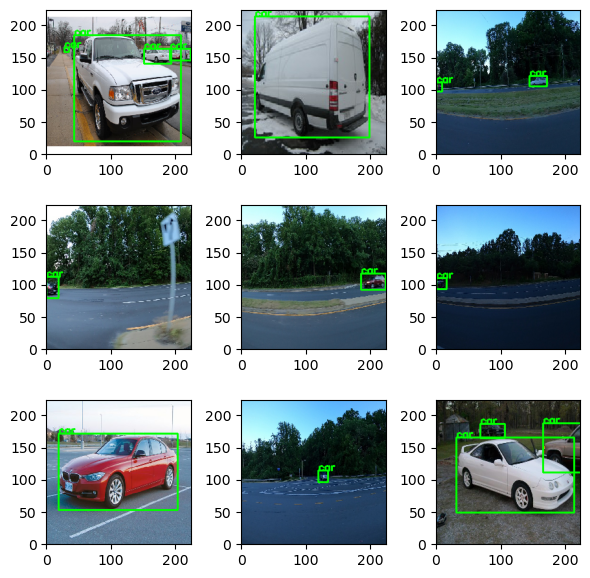

In [89]:
random_images(df_train, 9)

## Exportar dafaframe

In [ ]:
df_train.to_excel("df_train.xlsx")

# Fin de este notebook